# Convolutional neural networks for artistic style transfer

Этот блокнот IPython представляет собой реализацию популярной статьи ([Gatys et al., 2015](https://arxiv.org/abs/1508.06576)) в которой демонстрируется, как использовать нейронные сети для передачи художественного стиля с одного изображения на другое.  Тут теория и пояснения [related blog post](https://harishnarayanan.org/writing/artistic-style-transfer/).

Уже есть алгоритм быстрее ([Johnson et al., 2016](https://arxiv.org/abs/1603.08155))

In [1]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


## Load and preprocess the content and style images

Наша первая задача - загрузить контент и стилизовать изображения. Обратите внимание, что изображение контента, с которым мы работаем, не особенно высокого качества, но результат, который мы получим в конце этого процесса, все равно выглядит действительно хорошо.

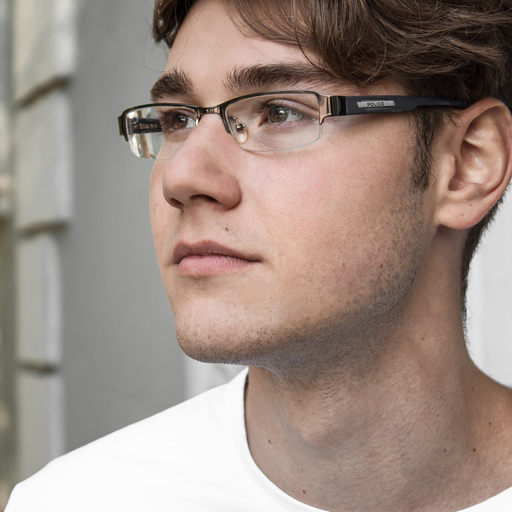

In [2]:
height = 512
width = 512

content_image_path = 'images/my.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image

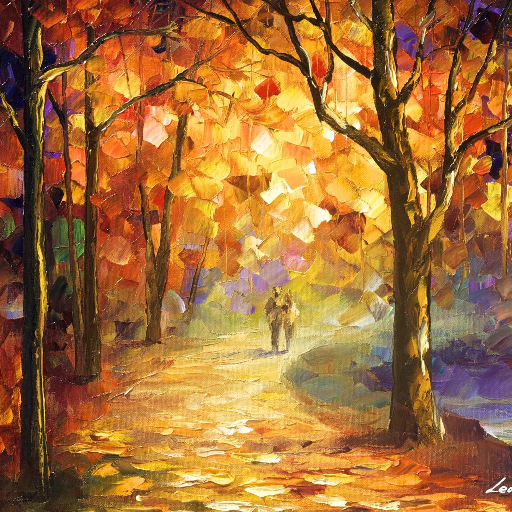

In [3]:
style_image_path = 'images/styles/forest.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

Затем мы конвертируем эти изображения в форму, подходящую для числовой обработки.
Обратите особое внимание, мы добавили еще одно измерение (высота х ширина х 3 измерения)

Так что позже мы сможем соединить представления этих двух изображений в общую структуру данных.

In [4]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


Прежде чем мы продвинемся дальше, нам нужно обработать эти входные данные, чтобы они соответствовали тому, что было сделано в [Simonyan and Zisserman (2015)](https://arxiv.org/abs/1409.1556), документ, в котором представлена модель * VGG Network *, которую мы используем.

Для этого нам нужно выполнить два преобразования::

1. Вычтите среднее значение RGB (computed previously on the [ImageNet training set](http://image-net.org)) от каждого пикселя.
2. Измените порядок расположения многомерного массива с *RGB* на *BGR* (порядок, используемый в статье).

In [5]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

Теперь мы можем использовать эти массивы для определения переменных в бэкэнде Keras (график TensorFlow).
Мы также ввели переменную-заполнитель для хранения сочетание-образ,
Это изображение сохраняет содержимое изображения содержимого при объединении стилей изображений стиля.

In [6]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

Наконец, мы объединяем все данные изображения в единый тензор, который подходит для обработки с помощью модели Keras VGG16.

In [7]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

## Reuse a model pre-trained for image classification to define loss functions

Основная идея, представленная [Gatys et al. (2015)](https://arxiv.org/abs/1508.06576) заключается в том, что сверточные нейронные сети (CNN), обученные классификации изображений, уже знают, как кодировать перцептивную и семантическую информацию об изображениях. Мы собираемся следовать их идее и использовать * функциональные пространства*, предоставляемые одной из таких моделей, для независимой работы с контентом и стилем изображений.

В оригинальной статье используется 19-слойная сетевая модель VGG из [Simonyan and Zisserman (2015)](https://arxiv.org/abs/1409.1556), но вместо этого мы собираемся следовать [Johnson et al. (2016)](https://arxiv.org/abs/1603.08155) и используйте 16-слойную модель (VGG 16). В этом выборе нет заметной качественной разницы, и мы немного выигрываем в скорости.

Кроме того, поскольку нас не интересует проблема классификации, нам не нужны полностью связанные слои или конечный классификатор softmax. Нам нужна только та часть модели, которая отмечена зеленым цветом в таблице ниже.

![VGG Network Architectures](images/vgg-architecture.png "VGG Network Architectures")

Для нас тривиально получить доступ к этой усеченной модели, потому что Keras поставляется с набором предварительно обученных моделей, включая интересующую нас модель VGG16. Обратите внимание, что, установив `include_top=False` в приведенном ниже коде, мы не включаем ни один из fully connected layers.

In [8]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

Как видно из приведенной выше таблицы, модель, с которой мы работаем, имеет много слоев. У Keras есть свои собственные названия для этих слоев. Давайте составим список этих имен, чтобы позже мы могли легко ссылаться на отдельные слои.

In [9]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

Если вы посмотрите на приведенный выше список, вы убедитесь, что мы включили в таблицу все элементы, которые хотели (ячейки отмеченные зеленым цветом). Обратите также внимание, что, поскольку мы предоставили Keras конкретный входной тензор, различные тензоры TensorFlow приобретают четко определенные формы.

---

Суть статьи, которую мы пытаемся воспроизвести, заключается в том, что [проблема переноса стиля может быть поставлена как проблема оптимизации](https://harishnarayanan.org/writing/artistic-style-transfer/), где функция потерь, которую мы хотим минимизировать, может быть разложена на три отдельные части: *content loss*, *style loss* и *total variation loss*.

Относительная важность этих терминов определяется набором скалярных весов. Они произвольны, но следующий набор был выбран после довольно продолжительных экспериментов, чтобы найти набор, который генерирует результат, эстетически приятный для меня.

In [10]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

Теперь мы будем использовать пространство признаков, предоставляемое конкретным слоем модели, чтобы определить эти три функции потерь. Сначала мы инициализируем общий убыток до 0, а затем добавляем его поэтапно.

In [11]:
loss = backend.variable(0.)

### The content loss

Что касается потери содержимого, мы следуем Johnson et al. (2016) и извлекаем функцию содержимого из `block2_conv2`, потому что первоначальный выбор в Gatys et al. (2015) (`block4_conv2`) теряет слишком много структурных деталей. И, по крайней мере, для лиц, я нахожу более эстетичным точное сохранение структуры исходного изображения контента.

Это различие между слоями показано в нескольких примерах на изображениях ниже.

![Content feature reconstruction](images/content-feature.png "Content feature reconstruction")

Потеря содержимого - это (масштабированное, возведенное в квадрат) евклидово расстояние между представлениями признаков контента и комбинированными изображениями.

In [12]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

### The style loss

Вот тут-то все и начинает становиться немного запутанным.

Для потери стиля мы сначала определяем нечто, называемое * матрицей грамм*. Члены этой матрицы пропорциональны ковариациям соответствующих наборов признаков и, таким образом, фиксируют информацию о том, какие признаки имеют тенденцию активироваться вместе. Фиксируя только эту совокупную статистику по всему изображению, они не обращают внимания на конкретное расположение объектов внутри изображения. Это то, что позволяет им собирать информацию о стиле независимо от содержания. (This is not trivial at all, and I refer you to [a paper that attempts to explain the idea](https://arxiv.org/abs/1606.01286).)

Правильно восстановив пространство признаков и взяв внешнее произведение, можно эффективно рассчитать матрицу Грама.

In [13]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

Потеря стиля - это тогда (масштабированная, возведенная в квадрат) норма Фробениуса разницы между матрицами Грамм изображений стиля и комбинации.

Опять же, в следующем коде я решил использовать элементы стиля из слоев, определенных в Johnson et al. (2016), а не Gatys et al. (2015), потому что я нахожу конечные результаты более эстетичными. 

In [14]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

### The total variation loss

Теперь мы вернулись к более простой основе.

Если бы вы решили проблему оптимизации только с помощью двух терминов потерь, которые мы ввели до сих пор (стиль и содержание), вы обнаружите, что выходные данные довольно шумные. Таким образом, мы добавляем еще один термин, называемый  [total variation loss](http://arxiv.org/abs/1412.0035) (термин регуляризации), который способствует пространственной плавности.

Вы можете поэкспериментировать с уменьшением `total_variation_weight` и поиграть с уровнем шума сгенерированного изображения.

In [15]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

## Define needed gradients and solve the optimisation problem

Теперь, когда мы обработали наши входные изображения и установили наши калькуляторы функций потерь, все, что нам осталось сделать, это определить градиенты общих потерь относительно комбинированного изображения и использовать эти градиенты для итеративного улучшения нашего комбинированного изображения, чтобы минимизировать потери.

Мы начнем с определения градиентов.

In [16]:
grads = backend.gradients(loss, combination_image)

Затем мы вводим класс `Evaluator`, который вычисляет потери и градиенты за один проход, извлекая их с помощью двух отдельных функций, `loss` и `grads`. Это сделано потому, что `scipy.optimize` требует отдельных функций для потерь и градиентов, но вычислять их отдельно было бы неэффективно.

In [ ]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

Теперь мы, наконец, готовы решить нашу проблему оптимизации. Это комбинированное изображение начинает свою жизнь как случайный набор (допустимых) пикселей, и мы используем [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS)  алгоритм (квази-ньютоновский алгоритм, который значительно быстрее сходится, чем стандартный градиентный спуск), чтобы итеративно улучшить его.

Мы останавливаемся после 10 итераций, потому что результат выглядит для меня хорошо, и потери перестают значительно уменьшаться.

In [ ]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    
    
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    
    

Start of iteration 0
Current loss value: 1.10988e+11
Iteration 0 completed in 147s
Start of iteration 1
Current loss value: 5.61729e+10
Iteration 1 completed in 149s
Start of iteration 2
Current loss value: 4.5002e+10
Iteration 2 completed in 142s
Start of iteration 3
Current loss value: 4.02219e+10
Iteration 3 completed in 144s
Start of iteration 4
Current loss value: 3.76043e+10
Iteration 4 completed in 145s
Start of iteration 5
Current loss value: 3.58967e+10
Iteration 5 completed in 145s
Start of iteration 6
Current loss value: 3.48707e+10
Iteration 6 completed in 145s
Start of iteration 7
Current loss value: 3.4202e+10
Iteration 7 completed in 144s
Start of iteration 8
Current loss value: 3.37389e+10
Iteration 8 completed in 151s
Start of iteration 9


Обратите внимание, что нам нужно подвергнуть наше выходное изображение преобразованию, обратному преобразованию, которое мы проделали с нашими входными изображениями, прежде чем это обретет смысл.

In [ ]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

image_final = Image.fromarray(x)
image_final.save('images/results/forest.jpg')

## Conclusion and further improvements

Каким бы красивым ни был вывод этого кода, процесс, который мы используем для его создания, довольно медленный. И независимо от того, насколько получится ускорить этот алгоритм (с помощью графических процессоров и креативных хаков), его решение все равно будет относительно дорогостоящей проблемой. Это происходит потому, что мы решаем целую проблему оптимизации каждый раз, когда хотим сгенерировать изображение.